In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
!pip install kaggle

In [10]:
!kaggle datasets download shonenkov/melanoma-merged-external-data-512x512-jpeg

100% 4.86G/4.86G [02:56<00:00, 24.5MB/s]
100% 4.86G/4.86G [02:56<00:00, 29.5MB/s]


In [11]:
!unzip melanoma-merged-external-data-512x512-jpeg.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: 512x512-test/512x512-test/ISIC_5473977.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5475115.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5475276.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5476552.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5477755.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5478624.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5483744.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5483787.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5484280.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5484843.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5485368.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5486638.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5486811.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5488695.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5488923.jpg  
  inflating: 512x512-test/512x512-test/ISIC_5490573.jpg  
  inflating: 51

In [12]:
!pip install opencv-python kaggle
!apt-get install libgl1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [13]:
import pandas as pd

from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.nn as nn

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.models as models

from torch.utils.data import DataLoader
import torchvision.utils as utils

import time
from tqdm import tqdm
import cv2
from PIL import Image
import torch.nn.functional as F
import numpy as np

In [14]:
# read the data
data_dir='./512x512-dataset-melanoma/512x512-dataset-melanoma/'
data=pd.read_csv('./marking.csv')

# balance the data a bit
df_0=data[data['target']==0].sample(6000,random_state=42)
df_1=data[data['target']==1]
data=pd.concat([df_0,df_1]).reset_index()

#prepare the data
labels=[]
images=[]
for i in range(data.shape[0]):
    images.append(data_dir + data['image_id'].iloc[i]+'.jpg')
    labels.append(data['target'].iloc[i])
df=pd.DataFrame(images)
df.columns=['images']
df['target']=labels

# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.2, random_state=1234)

In [15]:
df.head(10)

,images,target
0,./512x512-dataset-melanoma/512x512-dataset-mel...,0
1,./512x512-dataset-melanoma/512x512-dataset-mel...,0
2,./512x512-dataset-melanoma/512x512-dataset-mel...,0
3,./512x512-dataset-melanoma/512x512-dataset-mel...,0
4,./512x512-dataset-melanoma/512x512-dataset-mel...,0
5,./512x512-dataset-melanoma/512x512-dataset-mel...,0
6,./512x512-dataset-melanoma/512x512-dataset-mel...,0
7,./512x512-dataset-melanoma/512x512-dataset-mel...,0
8,./512x512-dataset-melanoma/512x512-dataset-mel...,0
9,./512x512-dataset-melanoma/512x512-dataset-mel...,0


In [16]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [17]:
class ImageDataset(Dataset):
    def __init__(self,data_paths,labels,transform=None,mode='train'):
         self.data=data_paths
         self.labels=labels
         self.transform=transform
         self.mode=mode

    def __len__(self):
       return len(self.labels)

    def __getitem__(self,idx):
        img_name = self.data[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=Image.fromarray(img)
        if self.transform is not None:
          img = self.transform(img)
        img=img.cuda()

        labels = torch.tensor(self.labels[idx]).cuda()

        return img, labels

train_dataset=ImageDataset(data_paths=X_train.values,labels=y_train.values,transform=train_transform)
val_dataset=ImageDataset(data_paths=X_val.values,labels=y_val.values,transform=val_transform)

train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)

In [18]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH

        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

In [19]:
class AttnVGG(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()
        net = models.vgg16_bn(pretrained=True)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        self.cls = nn.Linear(in_features=512+512+256, out_features=num_classes, bias=True)

       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)


        self.reset_parameters(self.cls)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)
    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = F.max_pool2d(block1, 2, 2) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = F.max_pool2d(block2, 2, 2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = F.max_pool2d(block3, 2, 2) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = F.max_pool2d(block4, 2, 2) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = F.max_pool2d(block5, 2, 2) # /32
        N, __, __, __ = pool5.size()

        g = self.pool(pool5).view(N,512)
        a1, g1 = self.attn1(pool3, pool5)
        a2, g2 = self.attn2(pool4, pool5)
        g_hat = torch.cat((g,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

In [20]:
model = AttnVGG(num_classes=1, normalize_attn=True)
model=model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 258MB/s]


In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

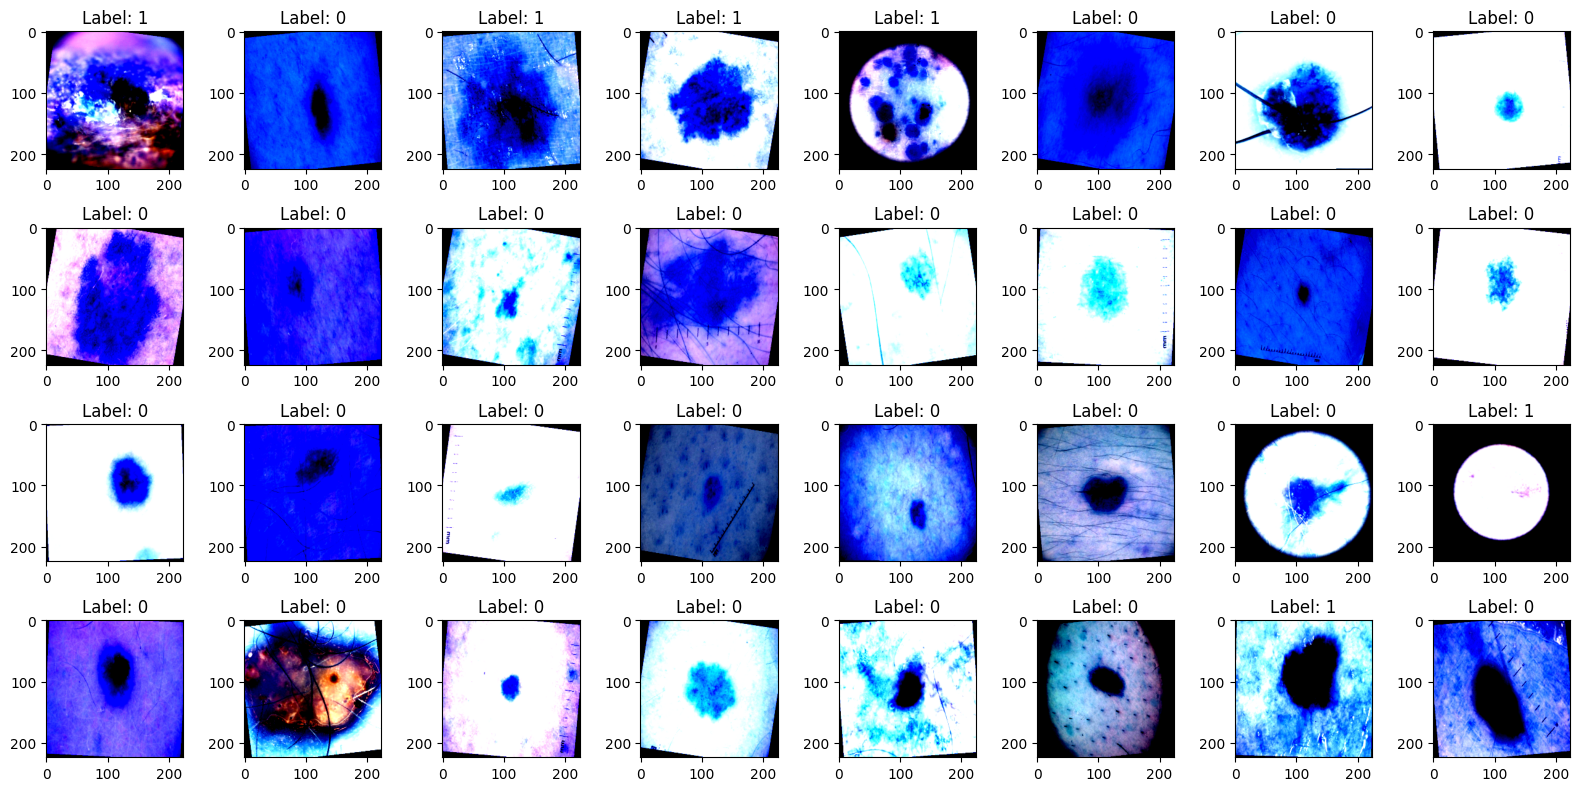

In [22]:
sample = iter(train_loader)
images, labels = next(sample)

images = images.cpu()

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for i, ax in enumerate(axes.ravel()):
    if i < 32:
        image = images[i].permute(1, 2, 0).numpy()  # Convert from tensor to numpy and rearrange dimensions if needed
        label = labels[i].item()
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
    else:
        ax.axis('off')  # Turn off empty subplots if there are fewer than 32 images

plt.tight_layout()
plt.show()

In [23]:


start_time = time.time()

epochs = 2

train_losses = []
train_auc=[]
val_auc=[]

for i in range(epochs):

    train_preds=[]
    train_targets=[]
    auc_train=[]
    loss_epoch_train=[]
    loss_epoch_test = []
    # Run the training batches
    for b, (X_train, y_train) in tqdm(enumerate(train_loader),total=len(train_loader)):
        b+=1
        y_pred,_,_= model(X_train)
        y_pred = y_pred.squeeze(dim=1)
        loss = criterion(torch.sigmoid(y_pred.type(torch.FloatTensor)), y_train.type(torch.FloatTensor))
        loss_epoch_train.append(loss.item())
        # For plotting purpose
        if (i==1):
            if (b==19):
                I_train = utils.make_grid(X_train[0:8,:,:,:], nrow=8, normalize=True, scale_each=True)
                __, a1, a2 = model(X_train[0:8,:,:,:])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    try:
        auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
    except:
        auc_train=0
    train_losses.append(np.mean(loss_epoch_train))
    train_auc.append(auc_train)
    print(f'epoch: {i:2}   loss: {np.mean(loss_epoch_train):10.8f} AUC  : {auc_train:10.8f} ')
    # Run the testing batches

    total_val = 0
    correct = 0
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(val_loader):
            y_val,_,_ = model(X_test)
            y_val = y_val.squeeze(dim=1)
            loss = criterion(torch.sigmoid(y_val.type(torch.FloatTensor)), y_test.type(torch.FloatTensor))
            loss_epoch_test.append(loss.item())

            total_val += y_test.size(0)
            correct += torch.eq(y_val, y_test).sum().double().item()
    auc_val = correct / total_val
    val_auc.append(auc_val)
    print(f'Epoch: {i} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

  0%|          | 0/144 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 144/144 [04:10<00:00,  1.74s/it]


epoch:  0   loss: 0.02864065 AUC  : 0.00000000 
Epoch: 0 Val Loss: 0.02544480 AUC: 0.00000000 


100%|██████████| 144/144 [03:58<00:00,  1.66s/it]


epoch:  1   loss: 0.02323563 AUC  : 0.00000000 
Epoch: 1 Val Loss: 0.02431484 AUC: 0.00000000 

Duration: 554 seconds


In [24]:
def visualize_attention(I_train,a,up_factor,no_attention=False):
    img = I_train.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    img=cv2.resize(img,(466,60))
    if no_attention:
        return torch.from_numpy(img)
    else:
        vis = 0.6 * img + 0.4 * attn
        return torch.from_numpy(vis)

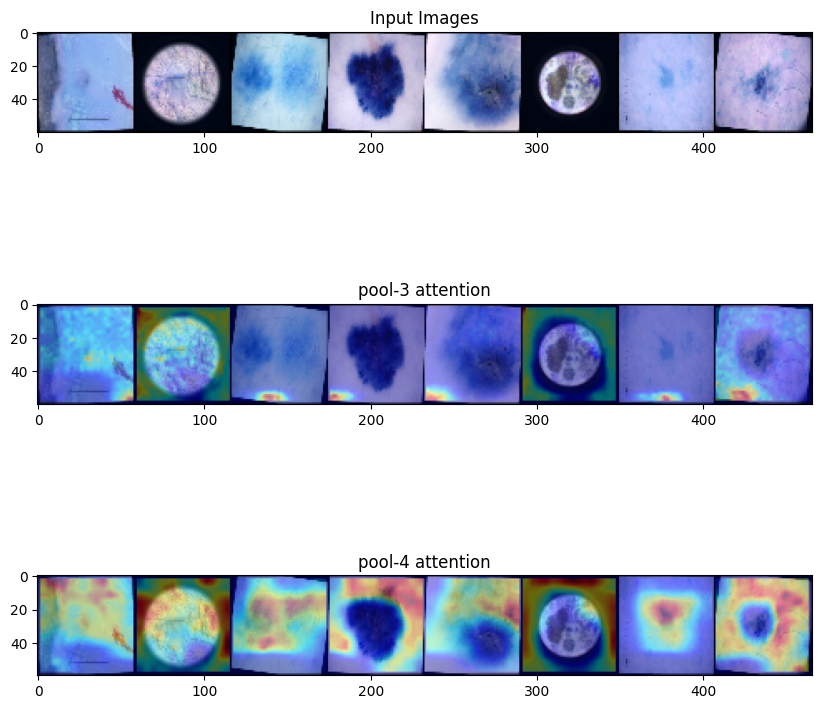

In [25]:
orig=visualize_attention(I_train,a1,up_factor=2,no_attention=True)
first=visualize_attention(I_train,a1,up_factor=2,no_attention=False)
second=visualize_attention(I_train,a2,up_factor=4,no_attention=False)

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(10, 10))
ax1.imshow(orig)
ax2.imshow(first)
ax3.imshow(second)
ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention')
ax3.title.set_text('pool-4 attention')